In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

C:\Users\jorah\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Configuración de estilo para las gráficas
plt.style.use('ggplot')

In [3]:
# Carga de los datos
df_train = pd.read_parquet('data_train.parquet')
df_test = pd.read_parquet('data_test.parquet')

# Combina ambos datasets, asegurando que los índices se reindexen de forma consecutiva
df = pd.concat([df_test, df_train], ignore_index=True)

# Asegura que la columna 'text' esté en formato string
df['text'] = df['text'].astype(str)


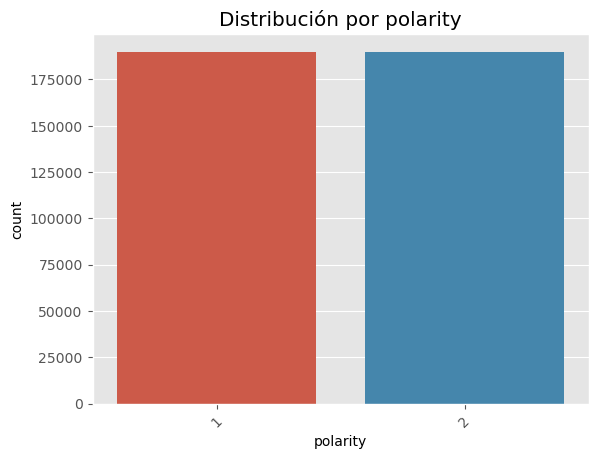

In [4]:
# Visualización básica de la distribución de polaridad
sns.countplot(data=df, x='polarity')
plt.title("Distribución por polarity")
plt.xticks(rotation=45)
plt.show()


In [5]:
# Elimina filas con valores nulos en las columnas 'text' y 'polarity'
df.dropna(subset=['text', 'polarity'], inplace=True)

# Función para preprocesar texto
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    # Convierte el texto a minúsculas y tokeniza
    words = word_tokenize(text.lower())
    # Filtra solo palabras alfanuméricas y elimina stop words
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return ' '.join(words)


In [ ]:
# Aplica preprocesamiento al texto
df['comentario_procesado'] = df['text'].apply(preprocess_text)

In [7]:
# Vectorización utilizando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['comentario_procesado'])

# Asegura que la polaridad esté correctamente etiquetada (1 = Negativo, 2 = Positivo)
y = df['polarity'].apply(lambda x: 1 if x == 1 else 0)


Esto crea una matriz TF-IDF donde cada fila representa un documento y cada columna representa un término del vocabulario (las características más relevantes) con su respectivo valor TF-IDF.

In [8]:
# Divide el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\jorah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [10]:
# Predicciones y evaluación del modelo
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.861421052631579
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86     37885
           1       0.86      0.86      0.86     38115

    accuracy                           0.86     76000
   macro avg       0.86      0.86      0.86     76000
weighted avg       0.86      0.86      0.86     76000



In [11]:
# Predicción para un nuevo comentario
nuevo_comentario = "I hate it."
nuevo_comentario_procesado = preprocess_text(nuevo_comentario)
nuevo_comentario_vectorizado = vectorizer.transform([nuevo_comentario_procesado])
prediccion = model.predict(nuevo_comentario_vectorizado)
print("Predicción para el nuevo comentario:", "Positivo" if prediccion[0] == 0 else "Negativo")

Predicción para el nuevo comentario: Negativo


In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print(cm)

[[32745  5140]
 [ 5392 32723]]


In [13]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

# Calcular probabilidades de predicción
y_prob = model.predict_proba(X_test)[:, 1]

Calculamos la probabilidad de predicción para obtener una medida más detallada de la confianza del modelo en su predicción. En lugar de simplemente decidir si una muestra pertenece a una clase o a otra (por ejemplo, positivo o negativo), el modelo también puede decirnos cuán seguro está de esa decisión.

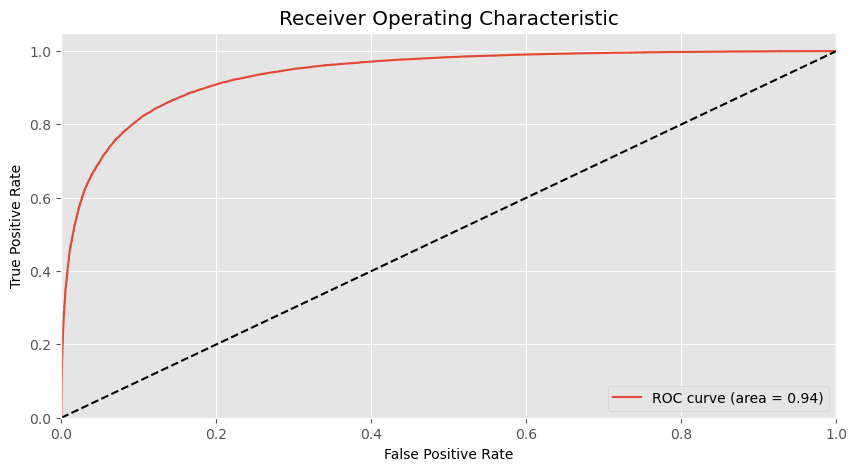

In [14]:
# Curva ROC y AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

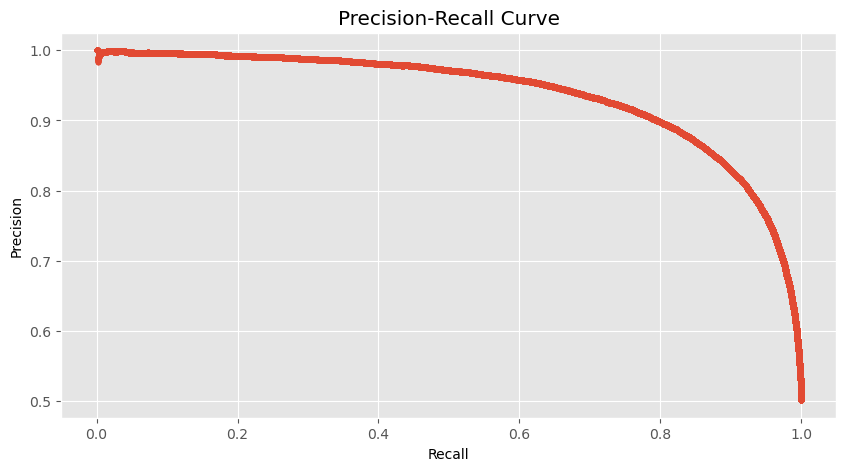

In [17]:
# Curva de precisión-recall
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(10, 5))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

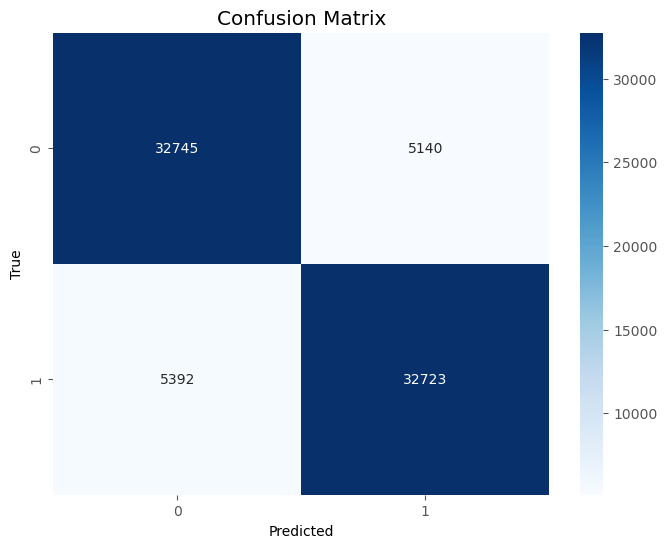

In [16]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()